# Titanic Survival Prediction
This ML Model will be used to predict passenger survival based on the dataset from Kaggle (https://www.kaggle.com/competitions/titanic). In this approach, we will be using a Tensorflow/Keras DNN to perform predictions on the test.csv file after training with the supplied train.csv file.

In [27]:
#Importing Libraries/Modules
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Data Preprocessing

First, lets open the csv file and preview the data.

In [13]:
#CSV Filepath
train_data_path = 'Data/train.csv'
test_data_path = 'Data/test.csv'

train_data = pd.read_csv(train_data_path, delimiter=',')
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


There are 890 rows of training data. As seen from above, the data requires cleaning & preprocessing before it can be fed into a Neural Network. 

First, we will drop the columns which are not relevant to training:
- PassengerId: We do not require the Passenger Id for training our model since it is just an index.
- Name: The name of the passenger is not required as it has no impact on the result.
- Ticket: This is just the ticket number, again this should not have an impact on the result.
- Cabin: This may have an impact on the result, however there are a large number of rows without a cabin value (only 204 out of 890) so this will be discarded.


In [14]:
train_data = train_data.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)
train_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


Now, we need to handle null values for the remaining columns:

In [15]:
train_data.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

From the output, it is evident that there are a significant number of rows without age. We have two options here - either discard null rows OR fill in the values using some statistical approaches like mean, mode etc. Since we only have around 800 rows of data, dropping ~170 rows would affect our training, so we will instead fill in with mean.
For the other column 'Embarked', we can just drop the rows since there are only 2 rows with missing data.

In [16]:
train_data = train_data.dropna(subset=['Embarked'])
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].mean())
train_data

/var/folders/94/j0q38tb53cddks5lvhm9vjlc0000gn/T/ipykernel_2900/1827510441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Age'] = train_data['Age'].fillna(train_data['Age'].mean())


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000000,1,0,7.2500,S
1,1,1,female,38.000000,1,0,71.2833,C
2,1,3,female,26.000000,0,0,7.9250,S
3,1,1,female,35.000000,1,0,53.1000,S
4,0,3,male,35.000000,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000,S
887,1,1,female,19.000000,0,0,30.0000,S
888,0,3,female,29.642093,1,2,23.4500,S
889,1,1,male,26.000000,0,0,30.0000,C


### Handling Categorical Values
For the columns with categorical values, we will perform one-hot encoding. Note that this is feasible only if the number of categories is not very large, because the cardinality of the dataset will increase. One-hot encoding is done to prevent the model from misinterpreting data (e.g. the model might think a pclass of 3 is greater than a pclass of 1)

In [17]:
#One-hot encoding the 'Sex' column
train_data = pd.concat([train_data, pd.get_dummies(train_data['Sex'])],axis=1)
#One-hot encoding the 'Pclass' column
train_data = pd.concat([train_data, pd.get_dummies(train_data['Pclass'], prefix='Pclass')],axis=1)
#One-hot encoding the 'Embarked' column
train_data = pd.concat([train_data, pd.get_dummies(train_data['Embarked'], prefix='Embarked')],axis=1)

#Dropping original columns since they are now encoded
train_data = train_data.drop(['Pclass','Sex','Embarked'], axis=1)
train_data

,Survived,Age,SibSp,Parch,Fare,female,male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,22.000000,1,0,7.2500,0,1,0,0,1,0,0,1
1,1,38.000000,1,0,71.2833,1,0,1,0,0,1,0,0
2,1,26.000000,0,0,7.9250,1,0,0,0,1,0,0,1
3,1,35.000000,1,0,53.1000,1,0,1,0,0,0,0,1
4,0,35.000000,0,0,8.0500,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.000000,0,0,13.0000,0,1,0,1,0,0,0,1
887,1,19.000000,0,0,30.0000,1,0,1,0,0,0,0,1
888,0,29.642093,1,2,23.4500,1,0,0,0,1,0,0,1
889,1,26.000000,0,0,30.0000,0,1,1,0,0,1,0,0


Now that the data has been cleaned, this will be our final dataset! The labels will be the first column (shape 888x1) and the input will be the remaining columns (input vector shape 888x12)

In [18]:
#Variables to store final vectors
train_input = []
train_labels = []
for index,row in train_data.iterrows() :
    #Append 1st column to labels
    train_labels.append(row['Survived'])
    #Append remaining columns to input
    train_input.append(row[1:])

#Convert to NP Arrays
train_input = np.asarray(train_input)
train_labels = np.asarray(train_labels)


## Building the Model
For this problem, we will be using a DNN model with the Keras Sequential API. The model architecture will comprise of:
1 Input Layer of 12 neurons, 2 Hidden Layers of 10,10 neurons , 1 Dropout Layer and 1 Output Layer of 1 neuron.

In [40]:
np.random.seed(173342) #Set seed for reproducability

model = tf.keras.models.Sequential([
    #Input Layer
    tf.keras.layers.Dense(12,input_shape=(None,12),activation="relu"),
    #1st Hidden Layer
    tf.keras.layers.Dense(12,activation="relu"),
    #2nd Hidden Layer
    tf.keras.layers.Dense(6,activation="relu"),
    #Output Layer which using sigmoid (because we just have two output classes)
    tf.keras.layers.Dense(1,activation="sigmoid")
])

#print model summary
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, None, 12)          156       
                                                                 
 dense_25 (Dense)            (None, None, 12)          156       
                                                                 
 dense_26 (Dense)            (None, None, 6)           78        
                                                                 
 dense_27 (Dense)            (None, None, 1)           7         
                                                                 
Total params: 397
Trainable params: 397
Non-trainable params: 0
_________________________________________________________________


### Training the Model
We will train the model for 200 epochs and a batch size of 32 (default). The optimizer used will be Adam (default learning rate) with the Binary Cross-Entropy Loss function.

Epoch 1/200
 1/45 [..............................] - ETA: 16s - loss: 7.7369 - accuracy: 0.3000

2022-07-21 22:46:56.078330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


45/45 [==============================] - 1s 9ms/step - loss: 3.8194 - accuracy: 0.4128
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 0.8289 - accuracy: 0.6693
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 0.6602 - accuracy: 0.6738
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 0.6216 - accuracy: 0.6704
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 0.6104 - accuracy: 0.6873
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 0.6045 - accuracy: 0.6805
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 0.5980 - accuracy: 0.6828
Epoch 8/200
45/45 [==============================] - 0s 8ms/step - loss: 0.5940 - accuracy: 0.6850
Epoch 9/200
45/45 [==============================] - 0s 7ms/step - loss: 0.5917 - accuracy: 0.6715
Epoch 10/200
45/45 [==============================] - 0s 7ms/step - loss: 0.5869 - accuracy: 0.6974
Epoch 11/200
45/45 [=

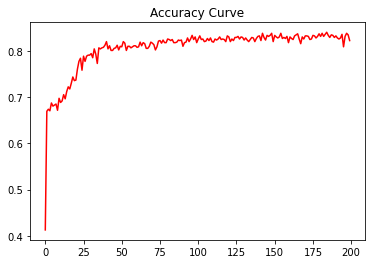

In [41]:
optimizer = tf.keras.optimizers.Adam()
lossFn = tf.keras.losses.BinaryCrossentropy()

#Compile the model
model.compile(loss=lossFn,optimizer=optimizer,metrics=["accuracy"])

#Training the model
history = model.fit(train_input,train_labels,epochs=200,batch_size=20)

#Plot the results
acc=history.history['accuracy']
epochs=range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r')
plt.title('Accuracy Curve')
plt.show()
print("")